In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, math
from functools import reduce
import statsmodels.api as sm
%matplotlib inline

学习一下包络算法大致上是怎么做的
首先， 我们需要计算滚动轴承的一些基本参数

BPFO,  外圈故障频率  $ BPFO = \dfrac{nf_s}{2}\left\{ 1 + \dfrac{d}{D} cos \alpha \right\} $

BPFI,  内圈故障频率  $ BPFI = \dfrac{nf_s}{2}\left\{ 1 - \dfrac{d}{D} cos \alpha \right\} $

FTF,    轴承基本频率  $ FTF = \dfrac{f_s}{2}\left\{1-\dfrac{d}{D}cos\alpha\right\} $

BSF,   滚珠故障频率  $ BSF = \dfrac{Df_s}{d}\left\{1-\left( \dfrac{d}{D}cos\alpha \right)^2\right\} $

其中$ D, d, \alpha, n, f_s $ 分别代表轴承直径， 滚珠直径， 滚珠和保持架的接触角， 滚珠个数， 轴承旋转频率。

In [2]:
sample_rate = 25600
f_s = 35
pitch_diameter = 39.80  / 1000
ball_diameter = 7.92 / 1000
contact_angle = 0
n_balls = 8
filename = "./35Hz12kN/Bearing1_2/120.csv"
df = pd.read_csv(filename)
df = df.rename(columns={"Horizontal_vibration_signals":"H", "Vertical_vibration_signals":"V"})

In [3]:
# 计算轴承的基本参数

bpfo = n_balls * f_s / 2.0 * ( 1 + ball_diameter / pitch_diameter * math.cos(contact_angle))
bpfi = n_balls * f_s / 2.0 * ( 1 - ball_diameter /pitch_diameter * math.cos(contact_angle))
ftf = f_s / 2.0 * (1 - ball_diameter/pitch_diameter * math.cos(contact_angle))
bsf = pitch_diameter * f_s / ball_diameter * ( 1 - ((ball_diameter / pitch_diameter)*math.cos(contact_angle))**2)

In [4]:
# 查找合适的ar参数
max_iterator = 400
N = len(df.V)
max_kurtosis = -10
max_p = 1
for p in range(1, max_iterator):
    ap, _ = sm.regression.linear_model.yule_walker(df.V, p)
    X = np.zeros((N, p))
    for i in range(0, p):
        X[i:, i] = df.V[0:N-i]
    xp = np.matmul(X , ap)
    e = df.V - xp
    k = sp.stats.kurtosis(e[p+1:])
    if k > max_kurtosis:
        max_kurtosis = k
        max_p = p

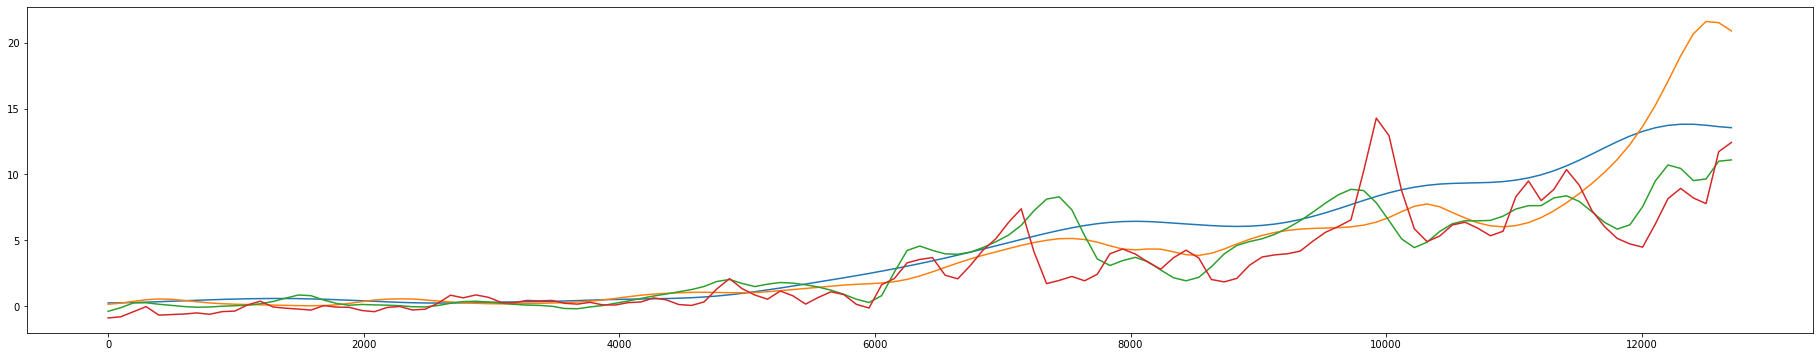

In [5]:
opt_a, _ = sm.regression.linear_model.yule_walker(df.V, max_p)
xp = sp.signal.lfilter(0-opt_a, 1, df.V)
e = df.V[max_p+1:] - xp [max_p+1:]
Ne = len(e)
win_length = [2**4, 2**5, 2**6, 2**7]
num_freq = np.max(win_length) + 1
spectrum_kurt = []

for i in range(len(win_length)):
    win_func = sp.signal.windows.hann(win_length[i])
    num_overlap =int(win_length[i]/2)
    num_window = int((Ne - num_overlap) / (win_length[i] - num_overlap))
    a,b = 0, win_length[i]
    STFT = np.zeros((num_window, num_freq))
    for t in range(0, num_window):
        stft = np.fft.fft(e[a:b] * win_func, 2 * (num_freq -1))
        stft = np.abs(stft[0:num_freq]) / win_length[i]/np.sqrt(np.mean(win_func **2))*2
        STFT[t,:] =  stft
        b += win_length[i] - num_overlap
        a += win_length[i] - num_overlap
    kurt = []
    for j in range(num_freq):
        kurt.append(sp.stats.kurtosis(STFT[:,j]))
    spectrum_kurt.append(kurt)
plt.figure(figsize=(32,6))
freq = np.arange(0, num_freq)/(2 * num_freq) * sample_rate
for i in range(len(spectrum_kurt)):
    plt.plot(freq, spectrum_kurt[i])
plt.show()

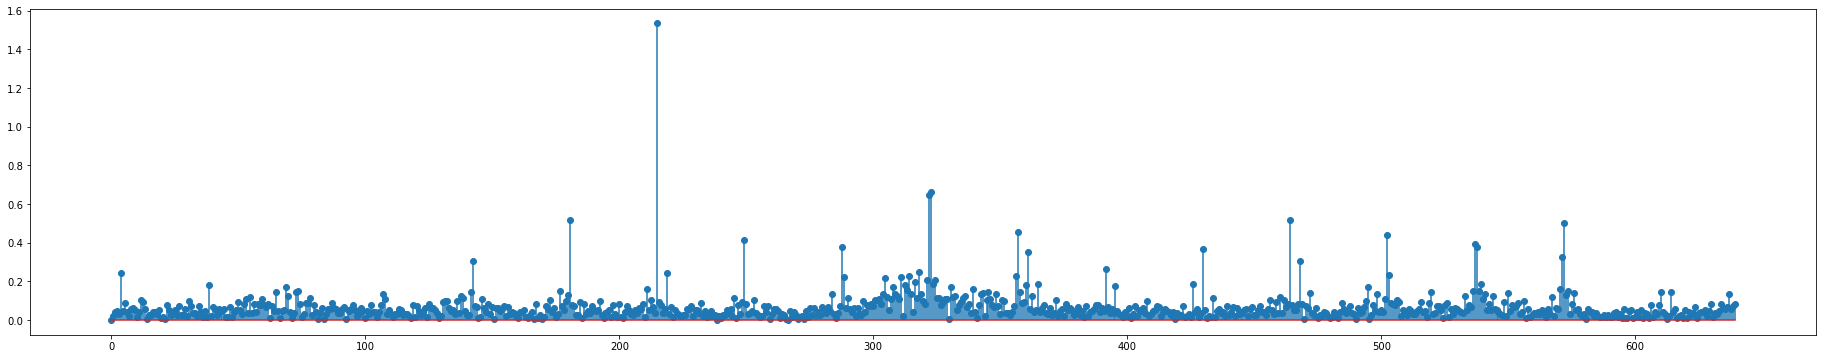

bpfo[167.85929648241205], bpfi[112.14070351758794], ftf[14.017587939698492], bsf[168.91901426323537]


In [6]:
band_pass = np.array([100, 1000])
(b, a) = sp.signal.butter(2, band_pass / (sample_rate/2), "bandpass")
X = sp.signal.lfilter(b, a, e)
ax = sp.signal.hilbert(X)
envel = np.abs(ax)
envel = envel - np.mean(envel)
fft_envel = np.abs(np.fft.fft(envel))/Ne * 2;
cutoff = int(N/40)
fft_envel = fft_envel[:cutoff]
freq = np.arange(Ne)/Ne*sample_rate
freq = freq[:cutoff]
plt.figure(figsize=(32,6))
plt.stem(freq, fft_envel)
plt.show()
print(f"bpfo[{bpfo}], bpfi[{bpfi}], ftf[{ftf}], bsf[{bsf}]")